In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split


from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Fragments
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdFMCS
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN5torch8autograd13_wrap_outputsERKSt6vectorIN2at6TensorESaIS3_EERKSt13unordered_setIPN3c1010TensorImplESt4hashISB_ESt8equal_toISB_ESaISB_EESJ_NS9_8ArrayRefINS9_8optionalIS3_EEEERKSt10shared_ptrINS0_4NodeEESt8functionIFS5_S5_S5_EE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_cluster/_graclus_cpu.so: undefined symbol: _ZN2at4_ops8randperm4callElN3c108optionalINS2_10ScalarTypeEEENS3_INS2_6LayoutEEENS3_INS2_6DeviceEEENS3_IbEE
  warnings.warn(f"An issue occurred while importi

Using device: cuda


In [2]:
df = pd.read_csv('/u/shaswata/scratch/Learning/xAI_Drug/tox21.csv')
    
df = df.dropna(subset=['NR-AhR', 'smiles'])

In [3]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic()),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalNumHs()
        ]
        atom_features.append(features)
    
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]]) 
        
        bond_features = [
            int(bond.GetBondType()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_features.extend([bond_features, bond_features])
    
    x = torch.tensor(atom_features, dtype=torch.float)
    
    if edge_indices:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)  
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [4]:
graphs = []
labels = []
valid_smiles = []

for idx, row in df.iterrows():
    smiles = row['smiles']
    label = int(row['NR-AhR'])
    
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)
        labels.append(label)
        valid_smiles.append(smiles)

for i, graph in enumerate(graphs):
    graph.y = torch.tensor([labels[i]], dtype=torch.long)

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42, 
                                           stratify=labels)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

[14:39:17] WARNING: not removing hydrogen atom without neighbors
[14:39:18] Explicit valence for atom # 3 Al, 6, is greater than permitted
[14:39:18] Explicit valence for atom # 4 Al, 6, is greater than permitted
[14:39:18] Explicit valence for atom # 4 Al, 6, is greater than permitted
[14:39:19] Explicit valence for atom # 9 Al, 6, is greater than permitted
[14:39:19] Explicit valence for atom # 5 Al, 6, is greater than permitted
[14:39:19] Explicit valence for atom # 16 Al, 6, is greater than permitted
[14:39:19] Explicit valence for atom # 20 Al, 6, is greater than permitted
/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:

class MPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, num_layers=3, num_classes=2):
        super(MPNNModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Input projection
        self.node_embedding = nn.Linear(node_dim, hidden_dim)
        
        # MPNN layers
        self.mpnn_layers = nn.ModuleList([
            MPNNLayer(hidden_dim, edge_dim, hidden_dim) 
            for _ in range(num_layers)
        ])
        
        # Output layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for mean and max pooling
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x, edge_index=None, edge_attr=None, batch=None):
        # Handle both data object and individual arguments
        if hasattr(x, 'x'):  # x is actually a data object
            data = x
            x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Initial node embedding
        x = self.node_embedding(x)
        
        # Apply MPNN layers only if there are edges
        if edge_index.size(1) > 0:
            for layer in self.mpnn_layers:
                x = layer(x, edge_index, edge_attr)
                x = F.relu(x)
        # If no edges, just apply activation to embedded features
        else:
            x = F.relu(x)
        
        # Graph-level representation
        graph_mean = global_mean_pool(x, batch)
        graph_max = global_max_pool(x, batch)
        graph_repr = torch.cat([graph_mean, graph_max], dim=1)
        
        # Classification
        out = self.classifier(graph_repr)
        return out

# Initialize model
node_dim = 7  # Number of atom features
edge_dim = 3  # Number of bond features
hidden_dim = 64

model = MPNNModel(node_dim, edge_dim, hidden_dim).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 85986 parameters


Starting training...
Epoch 000, Loss: 0.3944, Train Acc: 0.8504, Test Acc: 0.8824
Epoch 000, Loss: 0.3944, Train Acc: 0.8504, Test Acc: 0.8824
Epoch 010, Loss: 0.2908, Train Acc: 0.8834, Test Acc: 0.8915
Epoch 010, Loss: 0.2908, Train Acc: 0.8834, Test Acc: 0.8915
Epoch 020, Loss: 0.2659, Train Acc: 0.8888, Test Acc: 0.8953
Epoch 020, Loss: 0.2659, Train Acc: 0.8888, Test Acc: 0.8953
Epoch 030, Loss: 0.2458, Train Acc: 0.9022, Test Acc: 0.8969
Epoch 030, Loss: 0.2458, Train Acc: 0.9022, Test Acc: 0.8969
Epoch 040, Loss: 0.2271, Train Acc: 0.9132, Test Acc: 0.9053
Epoch 040, Loss: 0.2271, Train Acc: 0.9132, Test Acc: 0.9053
Epoch 050, Loss: 0.2140, Train Acc: 0.9188, Test Acc: 0.9083
Epoch 050, Loss: 0.2140, Train Acc: 0.9188, Test Acc: 0.9083
Epoch 060, Loss: 0.2001, Train Acc: 0.9255, Test Acc: 0.9083
Epoch 060, Loss: 0.2001, Train Acc: 0.9255, Test Acc: 0.9083
Epoch 070, Loss: 0.1884, Train Acc: 0.9329, Test Acc: 0.9083
Epoch 070, Loss: 0.1884, Train Acc: 0.9329, Test Acc: 0.9083
Epo

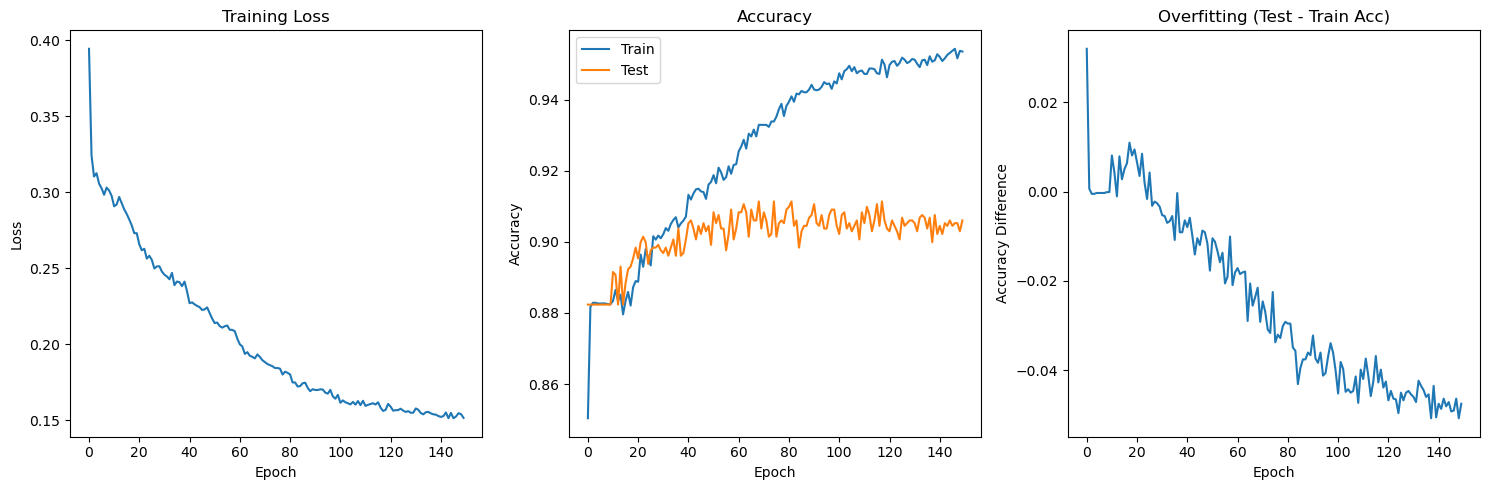

Final Train Accuracy: 0.9536
Final Test Accuracy: 0.9060


In [28]:
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
        
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch)
                pred = out.argmax(dim=1)
                test_correct += (pred == batch.y).sum().item()
                test_total += batch.y.size(0)
        
        test_acc = test_correct / test_total
        
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        scheduler.step()
        
        if epoch % 10 == 0:
            print(f'Loss: {avg_loss:.4f} \t Train Acc: {train_acc:.4f} \t Test Acc: {test_acc:.4f}')
    
    return train_losses, train_accs, test_accs

train_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, num_epochs=150)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(test_accs) - np.array(train_accs))
plt.title('Overfitting (Test - Train Acc)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference')

plt.tight_layout()
plt.show()

## GNN Explainer

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer
import json
from collections import defaultdict, Counter
from rdkit.Chem import rdFMCS
import pickle

def model_prediction(x, edge_index, edge_attr, batch):
    """Model prediction function for explainer"""
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
    model.eval()
    with torch.no_grad():
        out = model(data)
        return F.softmax(out, dim=1)

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='probs',
    ),
)


def explain_molecule(graph, smiles, explainer, threshold=0.6):
    model.eval()
    graph = graph.to(device)
    
    explanation = explainer(graph.x, graph.edge_index, 
                          edge_attr=graph.edge_attr, batch=None)
    
    with torch.no_grad():
        pred = model(graph)
        pred_probs = F.softmax(pred, dim=1)
        predicted_class = pred.argmax(dim=1).item()
        confidence = pred_probs[0, predicted_class].item()
    
    node_mask = explanation.node_mask
    edge_mask = explanation.edge_mask if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None else None
    
    important_nodes = torch.where(node_mask > threshold)[0].cpu().numpy()
    
    return {
        'smiles': smiles,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'node_mask': node_mask.cpu().numpy(),
        'edge_mask': edge_mask.cpu().numpy() if edge_mask is not None else None,
        'important_nodes': important_nodes,
        'explanation': explanation
    }

: 

In [33]:
toxic_explanations = []
non_toxic_explanations = []

print("Analyzing molecules from test set...")

model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1)
        test_predictions.extend(pred.cpu().numpy())
        test_true_labels.extend(batch.y.cpu().numpy())

test_start_idx = len(train_graphs)
test_smiles = valid_smiles[test_start_idx:]

toxic_indices = [i for i, (pred, true) in enumerate(zip(test_predictions, test_true_labels)) 
                 if pred == 1 and true == 1]  # Correctly predicted toxic
non_toxic_indices = [i for i, (pred, true) in enumerate(zip(test_predictions, test_true_labels)) 
                     if pred == 0 and true == 0]  # Correctly predicted non-toxic


num_to_analyze = len(toxic_indices)
selected_toxic = toxic_indices[:num_to_analyze]

num_non_toxic_analyze = min(100, len(non_toxic_indices))
selected_non_toxic = non_toxic_indices[:num_non_toxic_analyze]


for i, idx in enumerate(selected_toxic):
    graph = test_graphs[idx]
    smiles = test_smiles[idx]
    
    try:
        explanation = explain_molecule(graph, smiles, explainer, threshold=0.5)
        toxic_explanations.append(explanation)
    except Exception as e:
        print(f"Error explaining molecule {smiles}: {e}")
        continue

for i, idx in enumerate(selected_non_toxic):
    graph = test_graphs[idx]
    smiles = test_smiles[idx]
    
    try:
        explanation = explain_molecule(graph, smiles, explainer, threshold=0.5)
        non_toxic_explanations.append(explanation)
    except Exception as e:
        print(f"Error explaining molecule {smiles}: {e}")
        continue

Analyzing molecules from test set...
Found 91 correctly predicted toxic molecules
Found 1095 correctly predicted non-toxic molecules
Analyzing 91 toxic and 100 non-toxic molecules...
Explaining toxic molecule 1/91
Explaining toxic molecule 2/91
Explaining toxic molecule 2/91
Explaining toxic molecule 3/91
Explaining toxic molecule 3/91
Explaining toxic molecule 4/91
Explaining toxic molecule 4/91
Explaining toxic molecule 5/91
Explaining toxic molecule 5/91
Explaining toxic molecule 6/91
Explaining toxic molecule 6/91
Explaining toxic molecule 7/91
Explaining toxic molecule 7/91
Explaining toxic molecule 8/91
Explaining toxic molecule 8/91
Explaining toxic molecule 9/91
Explaining toxic molecule 9/91
Explaining toxic molecule 10/91
Explaining toxic molecule 10/91
Explaining toxic molecule 11/91
Explaining toxic molecule 11/91
Explaining toxic molecule 12/91
Explaining toxic molecule 12/91
Explaining toxic molecule 13/91
Explaining toxic molecule 13/91
Explaining toxic molecule 14/91
Ex

In [ ]:
def extract_submotif_from_explanation(smiles, important_nodes, min_size=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    
    submotifs = []
    
    important_set = set(important_nodes)
    
    G = nx.Graph()
    
    for node in important_nodes:
        G.add_node(node)
    
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        
        if begin_idx in important_set and end_idx in important_set:
            G.add_edge(begin_idx, end_idx)
    
    components = list(nx.connected_components(G))
    
    for component in components:
        if len(component) >= min_size:
            atom_indices = sorted(list(component))
            
            atoms = [mol.GetAtomWithIdx(int(i)).GetSymbol() for i in atom_indices]
            
            motif = '-'.join(atoms)
            submotifs.append({
                'motif': motif,
                'atoms': atoms,
                'indices': atom_indices,
                'size': len(component)
            })
    
    return submotifs

toxic_submotifs = []

for explanation in toxic_explanations:
    smiles = explanation['smiles']
    important_nodes = explanation['important_nodes']
    
    submotifs = extract_submotif_from_explanation(smiles, important_nodes)
    
    for submotif in submotifs:
        submotif['smiles'] = smiles
        submotif['confidence'] = explanation['confidence']
        submotif['predicted_class'] = explanation['predicted_class']
        toxic_submotifs.append(submotif)


non_toxic_submotifs = []

for explanation in non_toxic_explanations:
    smiles = explanation['smiles']
    important_nodes = explanation['important_nodes']
    
    submotifs = extract_submotif_from_explanation(smiles, important_nodes)
    
    for submotif in submotifs:
        submotif['smiles'] = smiles
        submotif['confidence'] = explanation['confidence']
        submotif['predicted_class'] = explanation['predicted_class']
        non_toxic_submotifs.append(submotif)



Extracting submotifs from toxic molecules...
Extracted 143 submotifs from toxic molecules
Extracting submotifs from non-toxic molecules...
Extracted 94 submotifs from non-toxic molecules


In [45]:
toxic_submotifs[23]

{'motif': 'C-Cl',
 'atoms': ['C', 'Cl'],
 'indices': [13, 14],
 'size': 2,
 'smiles': 'CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1.O=C(O)CC(O)(CC(=O)O)C(=O)O',
 'confidence': 0.8890395164489746,
 'predicted_class': 1}

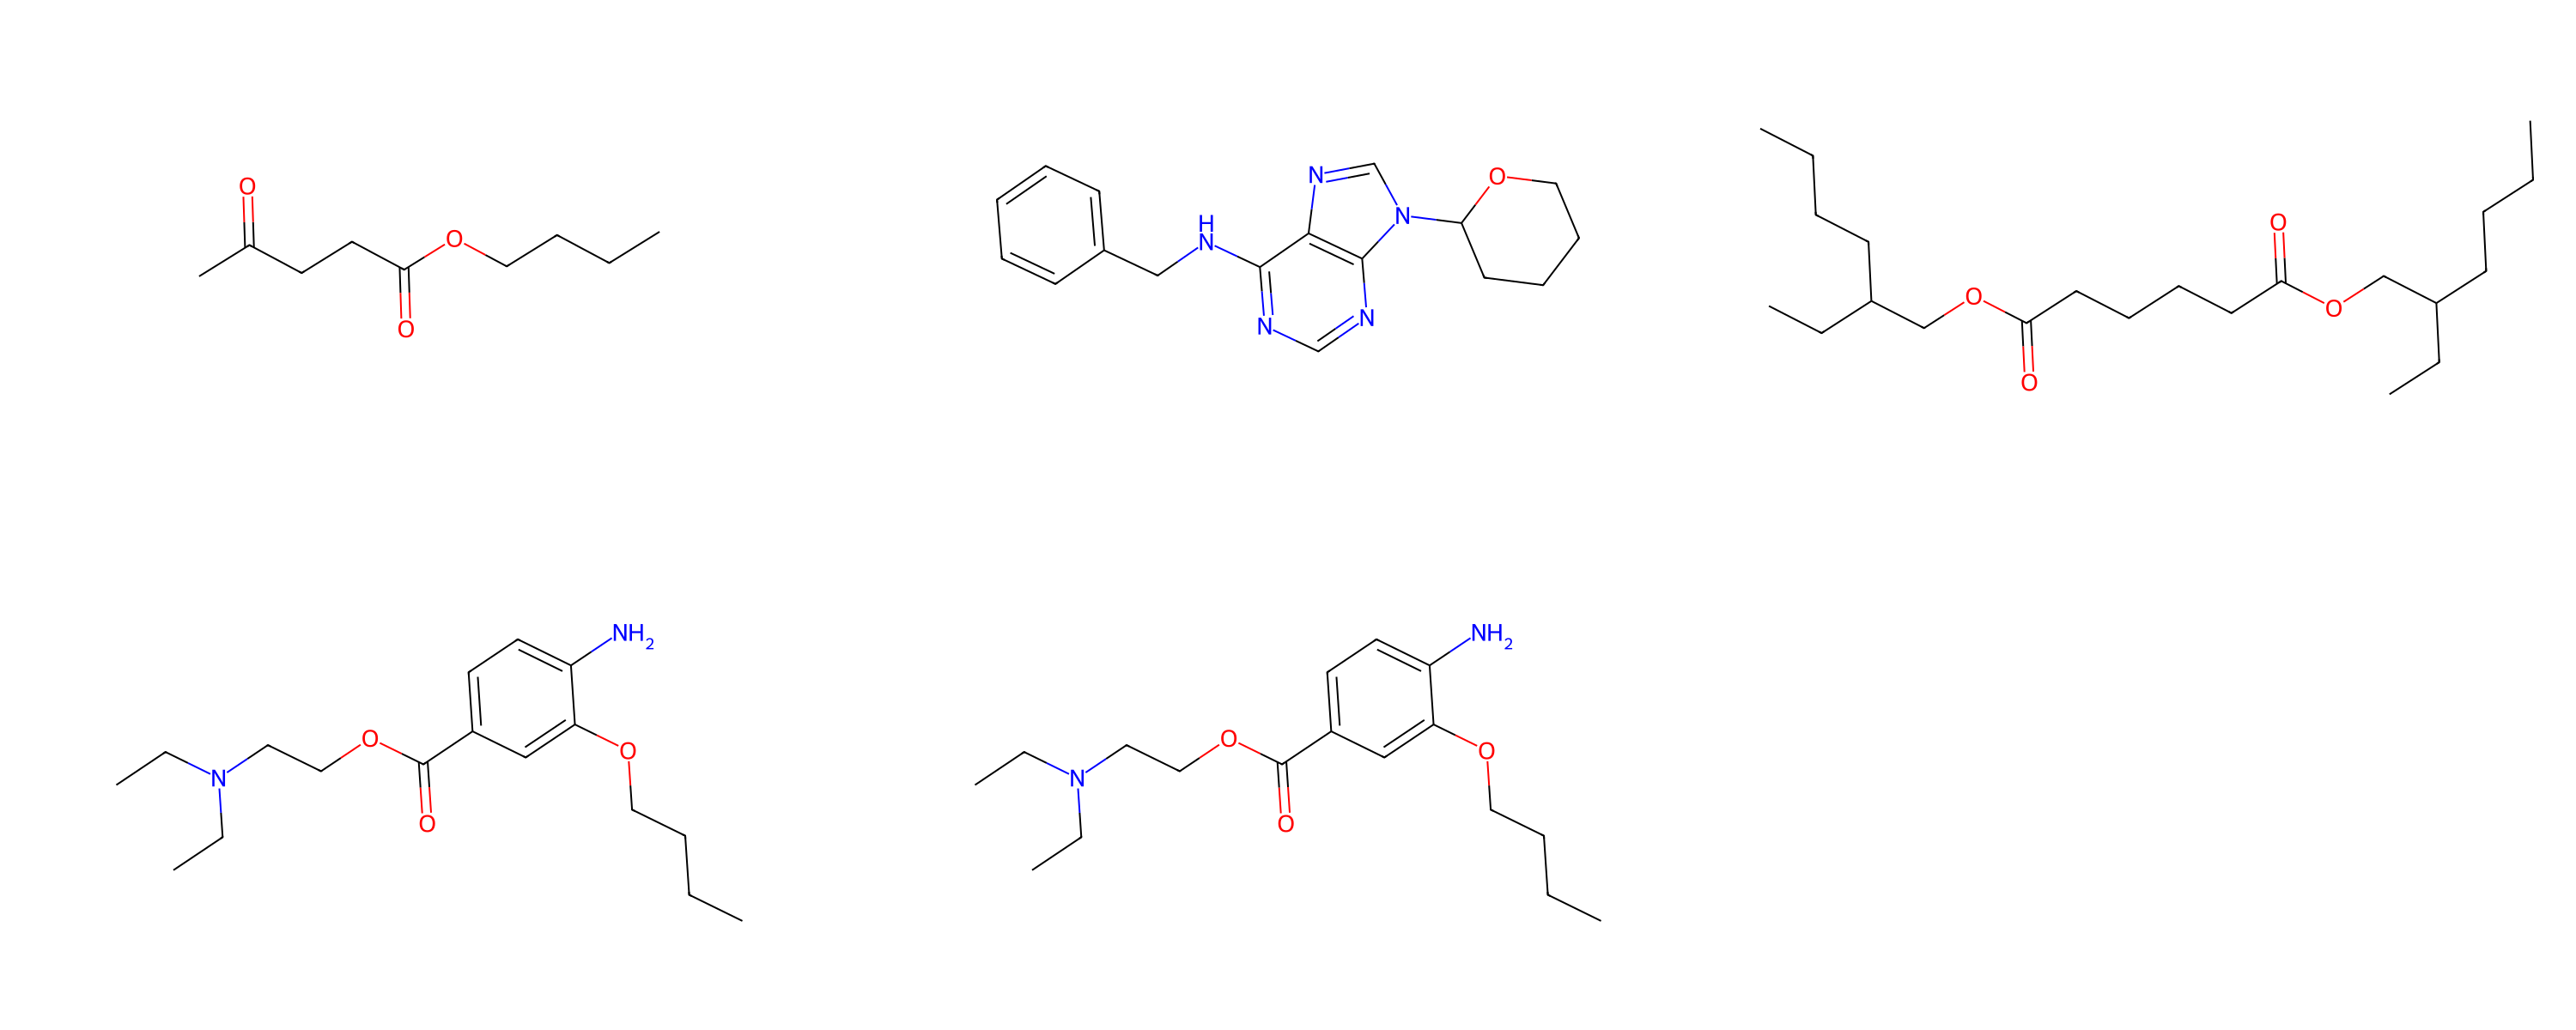

In [56]:
from rdkit.Chem import Draw

mols = [tsm['smiles'] for tsm in toxic_submotifs if tsm['confidence'] > 0.7]
example_mols = [Chem.MolFromSmiles(smiles) for smiles in mols[:5]]

img = Draw.MolsToGridImage(example_mols, molsPerRow=3, subImgSize=(1000,600))
img